In [70]:
#Bibliotecas
import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.bipartite.generators import complete_bipartite_graph
#Biblioteca para tratar intercalação e permutação, além da escolha aleatória
import itertools
from collections import defaultdict
from networkx.utils import arbitrary_element
import re
import unicodedata
from unicodedata import normalize
from fuzzywuzzy import fuzz, process

Alunos: Eduardo, Vitor, Daniel e Ricardo.

MIA: Análise de Dados em Grafos - PG-0083-23-X501

In [71]:
#Importando o Dataset
df_dados = pd.read_csv('ppgia_coautoria-bipartite.csv', delimiter=';', error_bad_lines=False, index_col=False, dtype='unicode', encoding='utf-8')

#Definindo a ANO como indice
df_dados.set_index('ANO', inplace=True)

#Ordenação por Autores ascedente
df_dados.sort_values(by=['AUTORES'], inplace=True)

#Criando o relacionamento
#df_dados['RELACAO'] = df_dados['TITULO']+';'+df_dados['AUTORES']

#Reordenando as colunas para uma melhor visualização
#df_dados = df_dados[['AUTORES', 'TITULO']]

#Exibir os dados
df_dados.head(15)

TITULO               AUTORES
ANO                                                                          
2013  The Crosscutting Impact Of The Aosd Brazilian ...   "Claudio Sant'Anna"
2019  Classification Of Eeg Signals To Detect Alcoho...  "Eug'Nio Peixoto Jr"
2010  Collective Intelligence In Law Enforcement Â  ...  "Johnatas D'Orleans"
2009  An Evaluation Of The Performance Impact Of Gen...  "Jonathan D'Orleans"
2019  Detecting Parkinson's Disease With Sustained P...   "Rytis Maskeli'Nas"
2010  Drilling Tool Geometry Evaluation For Reinforc...       A Aguiar Vieira
2013  Drilling Delamination Outcomes On Glass And Si...       A Aguiar Vieira
2019  Deep Learning Iot System For Online Stroke Det...       A C Da S Barros
2009  Phase Transformations Evaluation On An Uns S31...          A C G Varela
2005       Mechanical Evalution Of A Respiratory Device          A C Gastaldi
2009  A Framework For Community-Oriented Interactive...      A C Pascalicchio
2009              Cloud Computing And Reservoir Project               A Galis
2009              Cloud Computing And Reservoir Project                A Hohl
2010  Drilling Of Carbon Fibre Reinforced Laminates ...          A M Baptista
2013  Drilling Delamination Outcomes On Glass And Si...          A M Baptista

In [72]:
#Descrição Resumida
df_dados.describe()

TITULO  \
count                                                2370   
unique                                                478   
top     The Crosscutting Impact Of The Aosd Brazilian ...   
freq                                                   33   

                                 AUTORES  
count                               2370  
unique                               984  
top     Victor Hugo Costa De Albuquerque  
freq                                 158

In [73]:
#Descrição Resumida
df_dados.mean()

Series([], dtype: float64)

In [74]:
#Total de Registros
df_dados.shape

(2370, 2)

In [75]:
#Quantidade de Autores sem o tratamento
print('Qtde. Autores: ',len(pd.unique(df_dados['AUTORES'])))

Qtde. Autores:  984


In [76]:
#Quantidade de Titulos sem o tratamento
print('Qtde. Titulos: ',len(pd.unique(df_dados['TITULO'])))

Qtde. Titulos:  478


In [77]:
#Numero total de valores nulos por coluna
df_dados.isna().mean()

TITULO     0.0
AUTORES    0.0
dtype: float64

In [79]:
#Convertendo todo o Dataset para string
df_dados = df_dados.astype(str)

#Tipo dos dados do Dataframe
df_dados.dtypes

TITULO     object
AUTORES    object
dtype: object

#### Funções para realizar tratamento - Contribuição Ricardo

In [80]:
#Função para tratar o texto
def preparaListaTopMaisAutores(qtdeOcorrenciaCorte: int):
    df_aux = df_dados[(df_dados['AUTORES'].map(df_dados['AUTORES'].value_counts()) > qtdeOcorrenciaCorte) & (df_dados['PROCESSADO'] == 'N')]
    df_aux = df_aux.sort_values(by='AUTORES')
    top_autores = df_aux['AUTORES'].unique().tolist()
    if len(top_autores) >= 15:
        top_autores = top_autores[0:15]
    print('\n*** Top {} autores com mais de {} ocorrências:\n\n{} '.format(len(top_autores), qtdeOcorrenciaCorte, top_autores))
    return top_autores

def preparaListaTopNAutores(qtdeAutor: int):
    df_aux = df_dados[df_dados['PROCESSADO'] == 'N']
    df_aux = df_aux['AUTORES'].value_counts()
    top_autores = df_aux.index[0:qtdeAutor].tolist()
    #print('\n*** Top {} autores: \n\n{}'.format(qtdeAutor, top_autores))
    return top_autores

def atualizaListaCompletaAutores():
    #df_aux = df[df['PROCESSADO'] == 'N']
    df_aux = df_dados
    autores = df_aux['AUTORES'].unique().tolist()
    #print('\n*** Quantidade de nomes diferentes não processados: ', len(autores))
    return autores

def verificaSimilaridadeAutores(top_autores, autores, corte):
    print('\n*** Taxa de Similaridade:')
    for autor in autores:
        if process.extractOne(autor, top_autores, score_cutoff=corte, scorer=fuzz.token_set_ratio) is not None:
            print(autor, process.extractOne(autor, top_autores, score_cutoff=corte, scorer=fuzz.token_set_ratio))

def corrigeNomeAutor(top_autores, corte):
    for autor in top_autores:
        for item in df_dados.AUTORES.items():
            if fuzz.token_set_ratio(autor, item[1]) > corte:
                df_dados.loc[df_dados['AUTORES'] == item[1], ['AUTORES']] = autor
                df_dados.loc[df_dados['AUTORES'] == item[1], ['PROCESSADO']] = 'S'
                
def corrigeNomeAutorDif(top_autores, corte):
    for autor in top_autores:
        for item in df_dados.AUTORES.items():
            if autor != item[1]:
                if fuzz.token_set_ratio(autor, item[1]) > corte:
                    df_dados.loc[df_dados['AUTORES'] == item[1], ['AUTORES']] = autor
                    df_dados.loc[df_dados['AUTORES'] == item[1], ['PROCESSADO']] = 'S'
            else:
                df_dados.loc[df_dados['AUTORES'] == item[1], ['PROCESSADO']] = 'S'

In [81]:
df_dados = df_dados.sort_values(by='AUTORES')
df_dados['PROCESSADO'] = 'N'

#### Primeiro processamento - Contribuição Ricardo

In [82]:
valor_corte = 95
qtde_ocorrencia = 1
qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

while qtde_nao_processado > 0:
    lista_top_autores = preparaListaTopNAutores(qtde_ocorrencia)
    lista_autores = atualizaListaCompletaAutores()
    #verificaSimilaridadeAutores(lista_top_autores, lista_autores, valor_corte)
    corrigeNomeAutor(lista_top_autores, valor_corte)
    qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

#### Refazendo a busca por nomes comparando o um autor com os demais (CORTE >= 95) - Contribuição Ricardo

In [83]:
df_dados['PROCESSADO'] = 'N'
df_dados = df_dados.sort_values(by='AUTORES')
valor_corte = 90
qtde_ocorrencia = 1
qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

while qtde_nao_processado > 0:
    lista_top_autores = preparaListaTopNAutores(qtde_ocorrencia)
    lista_autores = atualizaListaCompletaAutores()
    #verificaSimilaridadeAutores(lista_top_autores, lista_autores, valor_corte)
    corrigeNomeAutor(lista_top_autores, valor_corte)
    qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

#### Refazendo a busca por nomes comparando o um autor com os demais (CORTE >= 90) - Contribuição Ricardo

In [84]:
df_dados['PROCESSADO'] = 'N'
df_dados = df_dados.sort_values(by='AUTORES')
valor_corte = 90
qtde_ocorrencia = 1
qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

while qtde_nao_processado > 0:
    lista_top_autores = preparaListaTopNAutores(qtde_ocorrencia)
    lista_autores = atualizaListaCompletaAutores()
    #verificaSimilaridadeAutores(lista_top_autores, lista_autores, valor_corte)
    corrigeNomeAutorDif(lista_top_autores, valor_corte)
    qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

In [85]:
#Função para tratar o texto
def tratamento_texto(sentence):
  
  #Deixar tudo minusculo para melhorar a comparacao
  #sentence = sentence.lower()
  #remove as quebras de linha
  sentence = re.sub(r'\n', '', sentence)
  #substitui tabulações por um espaço em branco
  sentence = re.sub(r'\t', ' ', sentence)
  #substitui um ou mais espaços em branco por um espaço
  sentence= re.sub(r'\s+', ' ', sentence, flags=re.I)
  #remove aspas e apóstofrOs
  sentence = re.sub('["‘’“”…]', '', sentence)
  #remove acentos
  sentence = normalize('NFKD', sentence)
  sentence = u"".join([c for c in sentence if not unicodedata.combining(c)])
  #sentence = re.sub('[^a-zA-Z0-9 \\\]', '', sentence)

  return sentence

#Tratamento dos campos
df_dados['TITULO'] = df_dados['TITULO'].apply(tratamento_texto)
df_dados['AUTORES'] = df_dados['AUTORES'].apply(tratamento_texto)

In [86]:
#Ordenando o Dataframe
df_dados = df_dados.sort_values(['AUTORES', 'TITULO'])

#Exibir os dados
df_dados.head(15)

TITULO           AUTORES  \
ANO                                                                         
2014  Delamination In Carbon/Epoxy Plates Drilling: ...   A Aguiar Vieira   
2013  Drilling Delamination Outcomes On Glass And Si...   A Aguiar Vieira   
2010  Drilling Tool Geometry Evaluation For Reinforc...   A Aguiar Vieira   
2019  Deep Learning Iot System For Online Stroke Det...   A C Da S Barros   
2009  Phase Transformations Evaluation On An Uns S31...      A C G Varela   
2005       Mechanical Evalution Of A Respiratory Device      A C Gastaldi   
2009  A Framework For Community-Oriented Interactive...  A C Pascalicchio   
2009              Cloud Computing And Reservoir Project           A Galis   
2009              Cloud Computing And Reservoir Project            A Hohl   
2013  Drilling Delamination Outcomes On Glass And Si...      A M Baptista   
2010  Drilling Of Carbon Fibre Reinforced Laminates ...      A M Baptista   
2016  Multi-Label Meta-Learning Approach For The Aut...      A M P Canuto   
2009              Cloud Computing And Reservoir Project      A Maraschini   
2008  A New Solution For Automatic Microstructures A...    A R Alexandria   
2010  Development Application And Evaluation Of A Co...    A R Alexandria   

     PROCESSADO  
ANO              
2014          S  
2013          S  
2010          S  
2019          S  
2009          S  
2005          S  
2009          S  
2009          S  
2009          S  
2013          S  
2010          S  
2016          S  
2009          S  
2008          S  
2010          S

In [34]:
#Remover Duplicidades
df_dados.drop_duplicates(keep = 'first', inplace = True)
df_dados.drop_duplicates(subset=["TITULO", "AUTORES"], keep = 'first', inplace = True)

In [87]:
#Visualizar novamente os dados
df_dados

TITULO          AUTORES  \
ANO                                                                        
2014  Delamination In Carbon/Epoxy Plates Drilling: ...  A Aguiar Vieira   
2013  Drilling Delamination Outcomes On Glass And Si...  A Aguiar Vieira   
2010  Drilling Tool Geometry Evaluation For Reinforc...  A Aguiar Vieira   
2019  Deep Learning Iot System For Online Stroke Det...  A C Da S Barros   
2009  Phase Transformations Evaluation On An Uns S31...     A C G Varela   
...                                                 ...              ...   
2020  Trustful Internet Of Surveillance Things Based...       Zhifan Gao   
2020  Unified Model For Interpreting Multi-View Echo...       Zhifan Gao   
2019  Artificial Intelligence Based Qos Optimization...      Zongwei Luo   
2020  Towards 5G-Enabled Self Adaptive Green And Rel...      Zongwei Luo   
2019  Towards An Optimal Resource Management For Iot...      Zongwei Luo   

     PROCESSADO  
ANO              
2014          S  
2013          S  
2010          S  
2019          S  
2009          S  
...         ...  
2020          S  
2020          S  
2019          S  
2020          S  
2019          S  

[2370 rows x 3 columns]

In [88]:
#Total de Registros
df_dados.shape

(2370, 3)

In [89]:
#Quantidade de Autores sem o tratamento
print('Qtde. Autores: ',len(pd.unique(df_dados['AUTORES'])))

Qtde. Autores:  828


In [90]:
#Quantidade de Titulos sem o tratamento
print('Qtde. Titulos: ',len(pd.unique(df_dados['TITULO'])))

Qtde. Titulos:  478


In [91]:
#Filtrar apenas o ano de 2005, para reduzir o tamanho da entrada e melhorar a visualização, indexado pelo ano
df_dados_filtrado = df_dados.filter(like = '2005', axis=0)

#Exibir o dado filtrado
df_dados_filtrado.head()

TITULO  \
ANO                                                       
2005       Mechanical Evalution Of A Respiratory Device   
2005  Enterprise-Oriented Software Development Envir...   
2005  Fatores De Sucesso E Dificuldades Na Implement...   
2005  Knowledge Management In A Software Development...   
2005  Reference Model For Software Process Improveme...   

                        AUTORES PROCESSADO  
ANO                                         
2005               A C Gastaldi          S  
2005  Adriano Bessa Albuquerque          S  
2005  Adriano Bessa Albuquerque          S  
2005  Adriano Bessa Albuquerque          S  
2005  Adriano Bessa Albuquerque          S

In [92]:
#Criação dos nós a partir do dataframe
G = nx.from_pandas_edgelist(df_dados, 'TITULO', 'AUTORES')

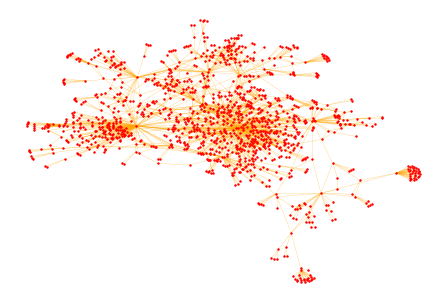

In [93]:
#Mostrar o Grafo sem os labels
nx.draw(G, pos=nx.spring_layout(G), with_labels=False, node_color='red', node_size=2, edge_color='orange', width=0.2)

Grafo é Bipartido.
Grafo está Conectado.
Densidade: 0.01
Espectro: 1.0
Vertices Isolados: []
Diametro: 12
Coeficiente de Clustering: 0.0
Distância Média entre nós: {6: 24.928571428571427, 3: 22.501010101010102, 8: 18.4375, 1: 8.840867992766727, 5: 26.538, 23: 3.0869565217391304, 2: 14.187830687830688, 4: 26.727678571428573, 7: 22.874285714285715, 28: 4.428571428571429, 9: 14.098765432098766, 10: 9.654545454545454, 12: 5.027777777777778, 33: 2.5454545454545454, 11: 5.03030303030303, 13: 3.3076923076923075, 20: 4.175, 30: 5.166666666666667, 26: 5.038461538461538, 42: 4.238095238095238, 43: 5.674418604651163, 19: 4.7631578947368425, 36: 3.3333333333333335, 40: 3.6, 38: 5.631578947368421, 123: 3.821138211382114, 167: 5.748502994011976}


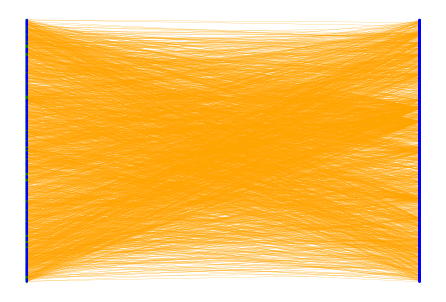

In [94]:
#Verifica se o grafo é bipartido
if nx.bipartite.is_bipartite(G):
    print('Grafo é Bipartido.')
    if nx.is_connected(G):
        print('Grafo está Conectado.')
        #Separar os dois conjuntos de vertices, verificação necessária porque se o Grafo não estiver conectado
        #Existirá mais de uma cor possível
        bottom_nodes, top_nodes = nx.bipartite.sets(G)
    else:
        top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
        bottom_nodes = set(G) - top_nodes
    
#Exibindo a densidade
print('Densidade:',round(nx.bipartite.density(G, bottom_nodes), 2))

#Exibindo o Espectro do Grafo Bipartido
print('Espectro:',nx.bipartite.spectral_bipartivity(G))

#Exibindo os vertices isolados
print('Vertices Isolados:',list(nx.isolates(G)))

#Exibindo o Diametro
print('Diametro:',nx.diameter(G))

#Exibindo o Coeficiente de Clustering
print('Coeficiente de Clustering:',nx.average_clustering(G))

#Exibindo a Distância entre nós
print('Distância Média entre nós:',nx.k_nearest_neighbors(G))
        
#Separar em cores
color_list = []
for v in bottom_nodes:
    color_list.append('green')
    G.nodes[v]['COR']= 'green'
for v in top_nodes:
    color_list.append('blue')
    G.nodes[v]['COR']= 'blue'

#Plotando o novo Grafo separando em cores o grafo bipartido
nx.draw(G, pos=nx.bipartite_layout(G, bottom_nodes), with_labels=False, node_color = color_list, node_size=2, edge_color='orange', width=0.2)

In [95]:
print('Nro de Arestas: {}'.format(G.number_of_edges()))
print('Nro de Vertices: {}'.format(G.number_of_nodes()))

Nro de Arestas: 2178
Nro de Vertices: 1306


In [96]:
#Martiz de Adjacencia
nx.to_pandas_adjacency(G, nodelist=sorted(G.nodes()), dtype='int')

Escritorio De Projetos: Caracteristicas Vantagens E O Planejamento De Sua Implantacao No Setor Publico  \
 Escritorio De Projetos: Caracteristicas Vantag...                                                  0                                                         
'Processo De Planejamento Para Producao Execuca...                                                  0                                                         
A #Hashtagtokenizer For Social Media Messages                                                       0                                                         
A Aguiar Vieira                                                                                     0                                                         
A Biclustering Approach For Classification With...                                                  0                                                         
...                                                                                               ...                                                         
Zairan Li                                                                                           0                                                         
Zehong Cao                                                                                          0                                                         
Zhenzhong Liu                                                                                       0                                                         
Zhifan Gao                                                                                          0                                                         
Zongwei Luo                                                                                         0                                                         

                                                    'Processo De Planejamento Para Producao Execucao E Avaliacao De Conteudos Crossmidiaticos Educativos E Televisivos  \
 Escritorio De Projetos: Caracteristicas Vantag...                                                  0                                                                    
'Processo De Planejamento Para Producao Execuca...                                                  0                                                                    
A #Hashtagtokenizer For Social Media Messages                                                       0                                                                    
A Aguiar Vieira                                                                                     0                                                                    
A Biclustering Approach For Classification With...                                                  0                                                                    
...                                                                                               ...                                                                    
Zairan Li                                                                                           0                                                                    
Zehong Cao                                                                                          0                                                                    
Zhenzhong Liu                                                                                       0                                                                    
Zhifan Gao                                                                                          0                                                                    
Zongwei Luo                                                                                         0                                                                    

                                                    A #Hashtagtokenizer For Social Media Messages  \
 E

Grafo é Bipartido.
Grafo está Conectado.
Densidade: 0.01
Espectro: 1.0
Vertices Isolados: []
Diametro: 12
Coeficiente de Clustering: 0.0
Distância Média entre nós: {6: 24.928571428571427, 3: 22.501010101010102, 8: 18.4375, 1: 8.840867992766727, 5: 26.538, 23: 3.0869565217391304, 2: 14.187830687830688, 4: 26.727678571428573, 7: 22.874285714285715, 28: 4.428571428571429, 9: 14.098765432098766, 10: 9.654545454545454, 12: 5.027777777777778, 33: 2.5454545454545454, 11: 5.03030303030303, 13: 3.3076923076923075, 20: 4.175, 30: 5.166666666666667, 26: 5.038461538461538, 42: 4.238095238095238, 43: 5.674418604651163, 19: 4.7631578947368425, 36: 3.3333333333333335, 40: 3.6, 38: 5.631578947368421, 123: 3.821138211382114, 167: 5.748502994011976}


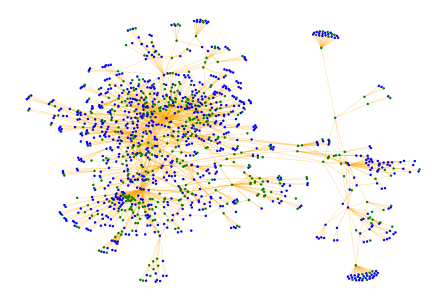

In [97]:
#Verifica se o grafo é bipartido
if nx.bipartite.is_bipartite(G):
    print('Grafo é Bipartido.')
    if nx.is_connected(G):
        print('Grafo está Conectado.')
        #Separar os dois conjuntos de vertices, verificação necessária porque se o Grafo não estiver conectado
        #Existirá mais de uma cor possível
        bottom_nodes, top_nodes = nx.bipartite.sets(G)
    else:
        top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
        bottom_nodes = set(G) - top_nodes
    
#Exibindo a densidade
print('Densidade:',round(nx.bipartite.density(G, bottom_nodes), 2))

#Exibindo o Espectro do Grafo Bipartido
print('Espectro:',nx.bipartite.spectral_bipartivity(G))

#Exibindo os vertices isolados
print('Vertices Isolados:',list(nx.isolates(G)))

#Exibindo o Diametro
print('Diametro:',nx.diameter(G))

#Exibindo o Coeficiente de Clustering
print('Coeficiente de Clustering:',nx.average_clustering(G))

#Exibindo a Distância entre nós
print('Distância Média entre nós:',nx.k_nearest_neighbors(G))
        
#Separar em cores
color_list = []
for v in bottom_nodes:
    color_list.append('green')
    G.nodes[v]['COR']= 'green'
for v in top_nodes:
    color_list.append('blue')
    G.nodes[v]['COR']= 'blue'

#Plotando o novo Grafo separando em cores o grafo bipartido
nx.draw(G, pos=nx.spring_layout(G), with_labels=False, node_color = color_list, node_size=2, edge_color='orange', width=0.2)

### Gerar um gráfico com a Frequência x Valor Link - Contribuição Ricardo

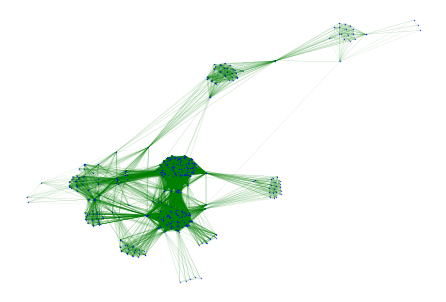

In [99]:
# Porjeção do Grafo
Gp = nx.bipartite.projected_graph(G, bottom_nodes)
nx.draw(Gp, node_size=0.1, node_color='b', edge_color='g', width=0.05)

In [100]:
df_dadosrdz = df_dados

#Reduzindo o tamanho dos labels para que a plotagem fique nitida, tamanho 10, apenas para fins didádicos
for i in range(0, len(df_dados)):
    df_dadosrdz.iloc[i].TITULO = df_dadosrdz.iloc[i].TITULO[:10]
    df_dadosrdz.iloc[i].AUTORES = df_dadosrdz.iloc[i].AUTORES[:10]

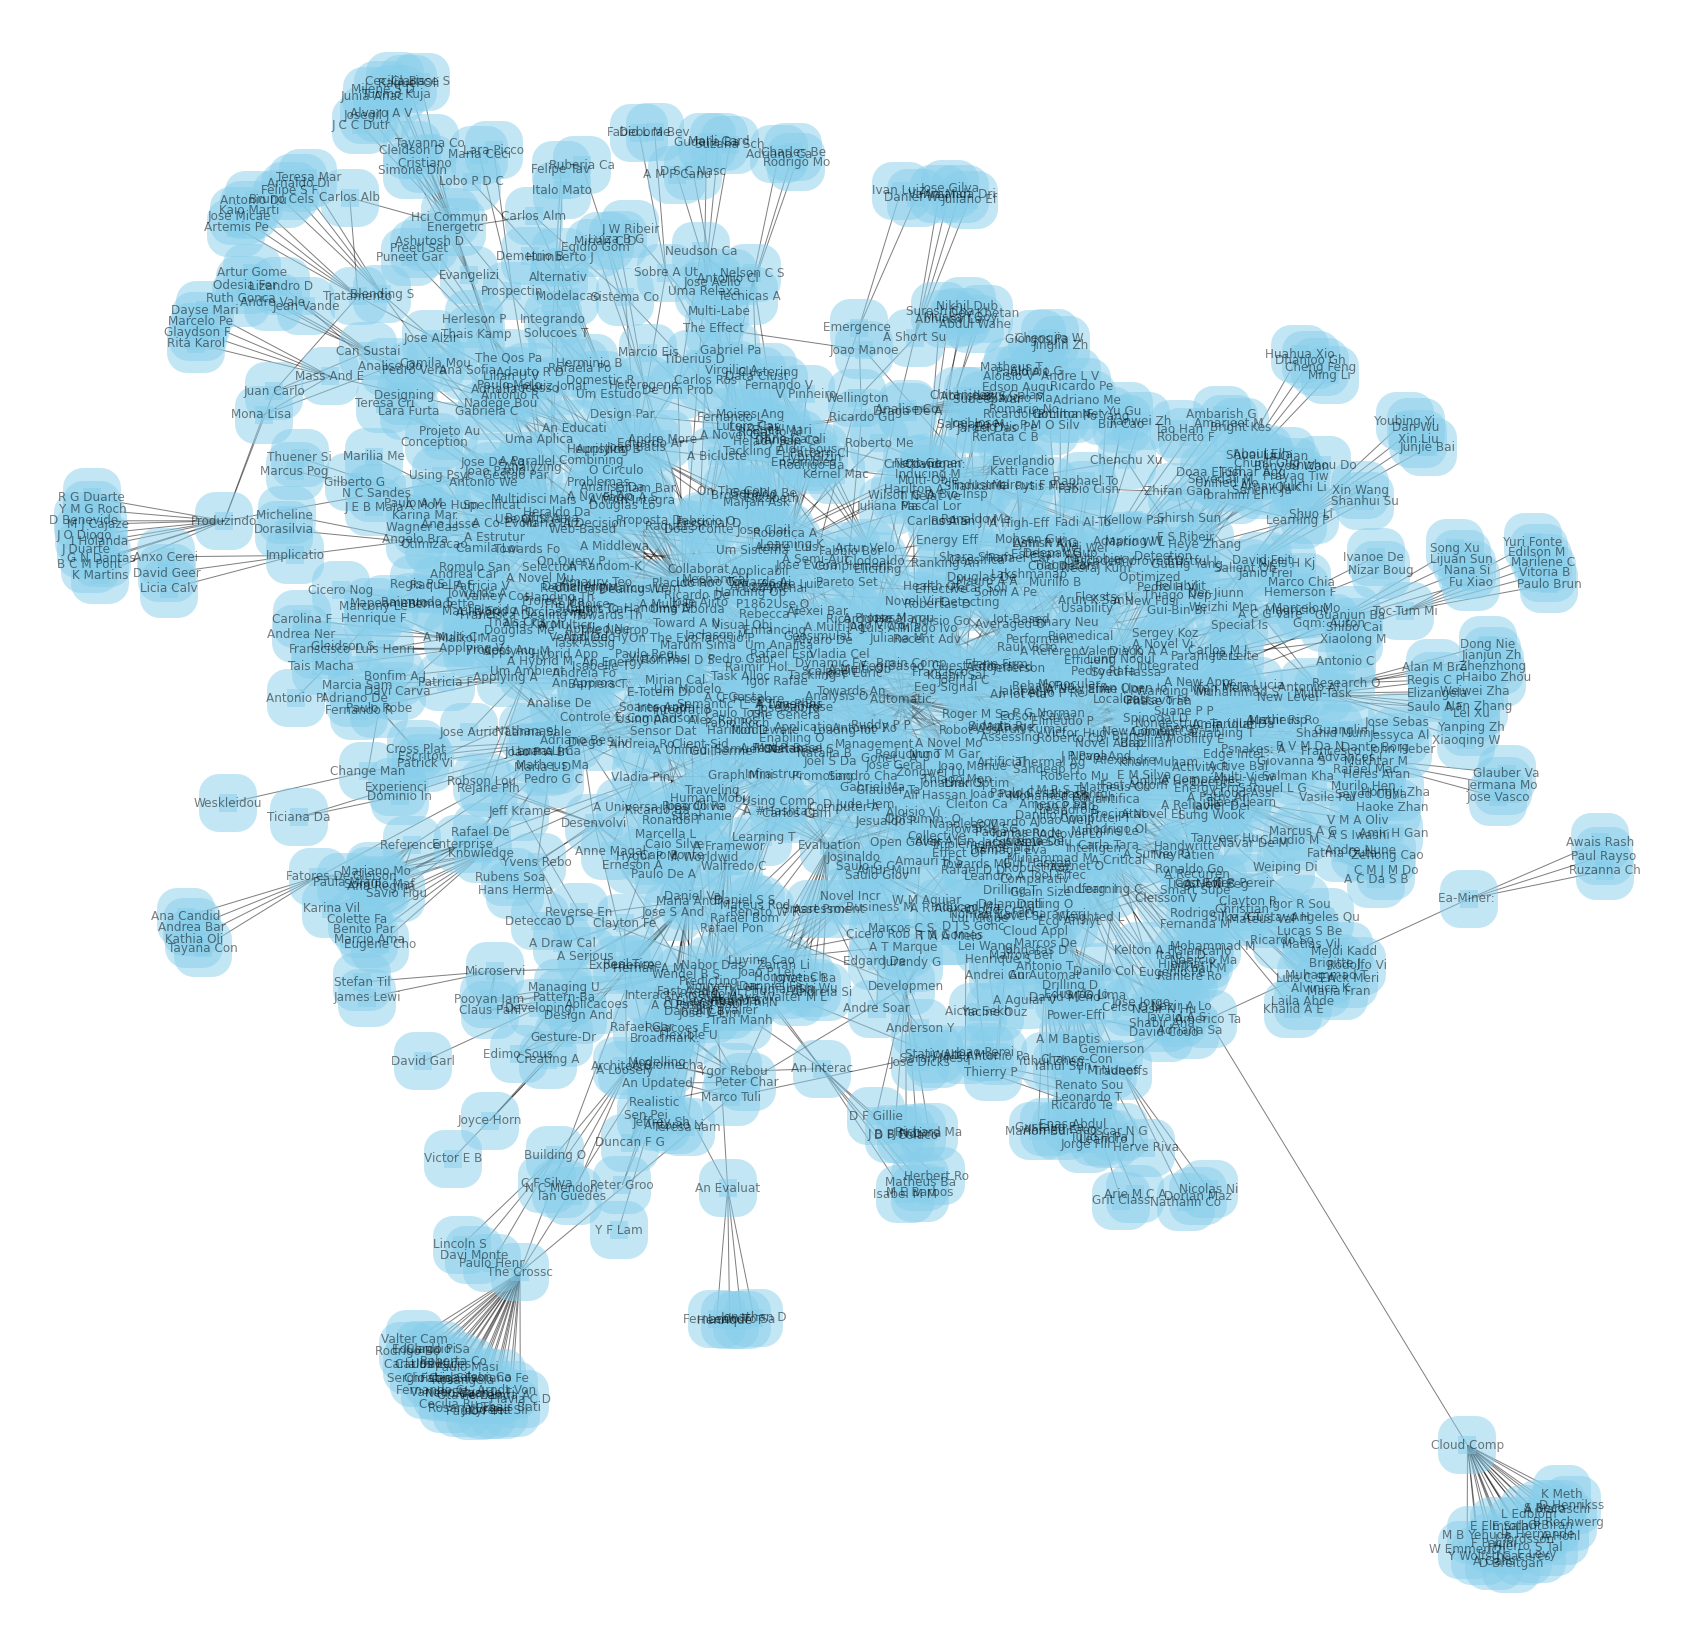

In [101]:
#Criação dos nós a partir do dataframe
Gredz = nx.from_pandas_edgelist(df_dados, 'TITULO', 'AUTORES')

#Plotando um novo grafo tentando melhorar a visualização, agora com os labels com 10 de tamanho cada
fig, ax = plt.subplots(figsize=(30,30))
nx.draw(Gredz, with_labels=True, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)
plt.show()

Grafo é Bipartido.
Grafo está Conectado.
Densidade: -0.0
Espectro: 1.0


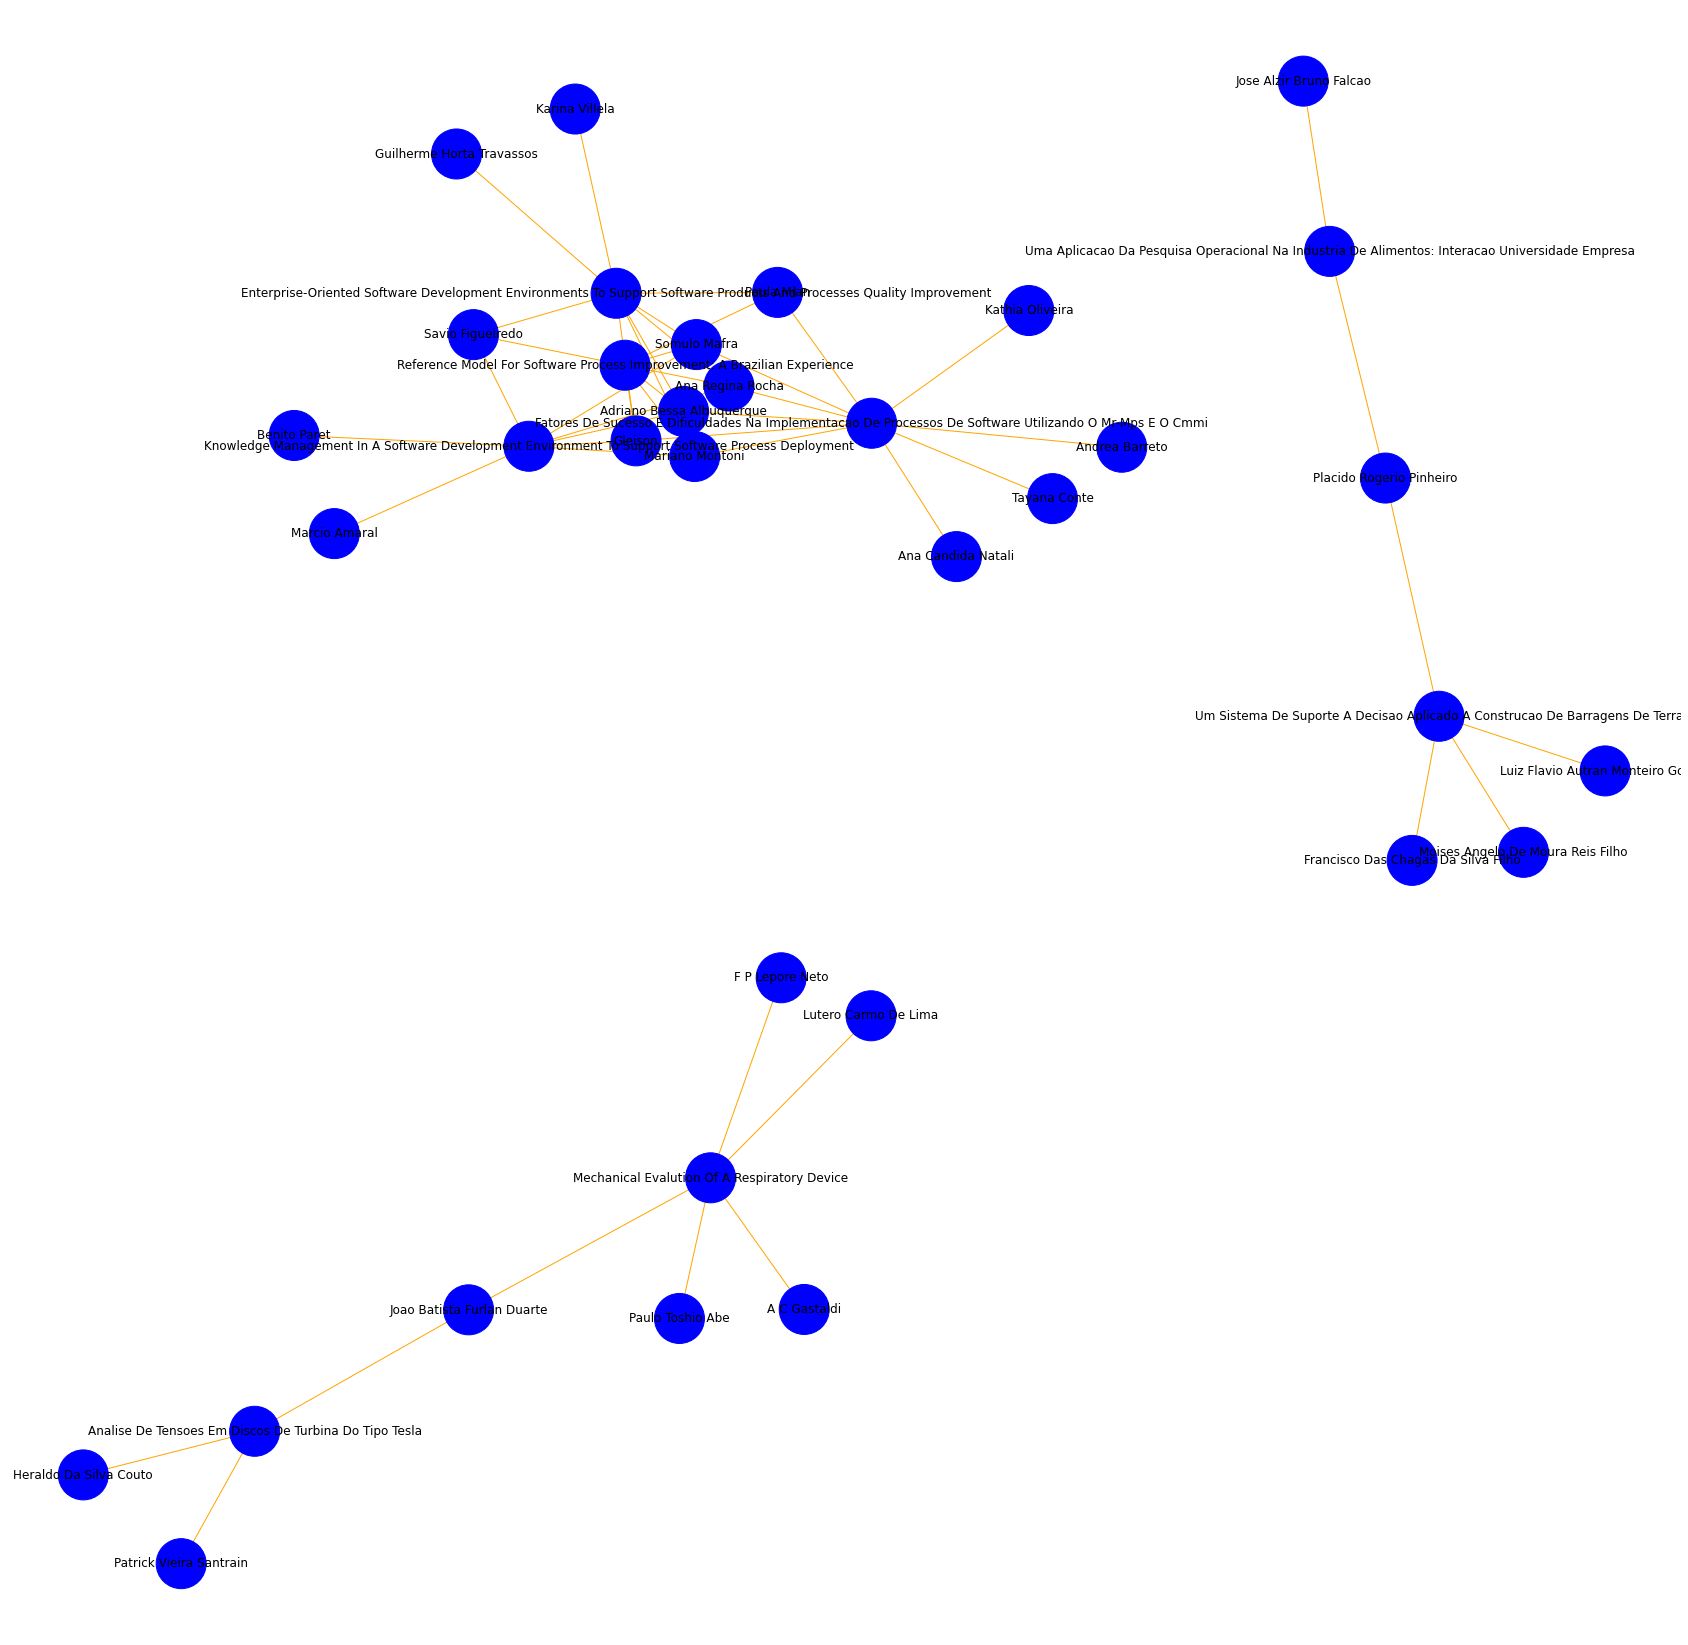

In [102]:
#Criando o grafo filtrado por ano = 2005, percebemos que gera uma densidade negativa, quando filtramos a entrada
G1 = nx.from_pandas_edgelist(df_dados_filtrado, 'TITULO', 'AUTORES')

#Verifica se o grafo é bipartido
if nx.bipartite.is_bipartite(G1):
    print('Grafo é Bipartido.')
    if nx.is_connected(G1):
        print('Grafo está Conectado.')
    else:
        print('Grafo está Conectado.')
else:
    print('Grafo é Monopartido.')

#Exibindo a densidade
print('Densidade:',round(nx.bipartite.density(G1, bottom_nodes), 2))

#Exibindo o Espectro do Grafo Bipartido
print('Espectro:',nx.bipartite.spectral_bipartivity(G1))
    
#Plotando o Grafo
colors = ["blue" for n in G1.nodes(data=True)]
fig, ax = plt.subplots(figsize=(30,30))
node_size = [2500 for node in G1.nodes]
nx.draw_networkx(G1, node_size=node_size, node_color=colors, edge_color='orange')
plt.axis("off")
plt.show()

#### Representação da conversão de Grafo Bipartido para Monopartido ponderado

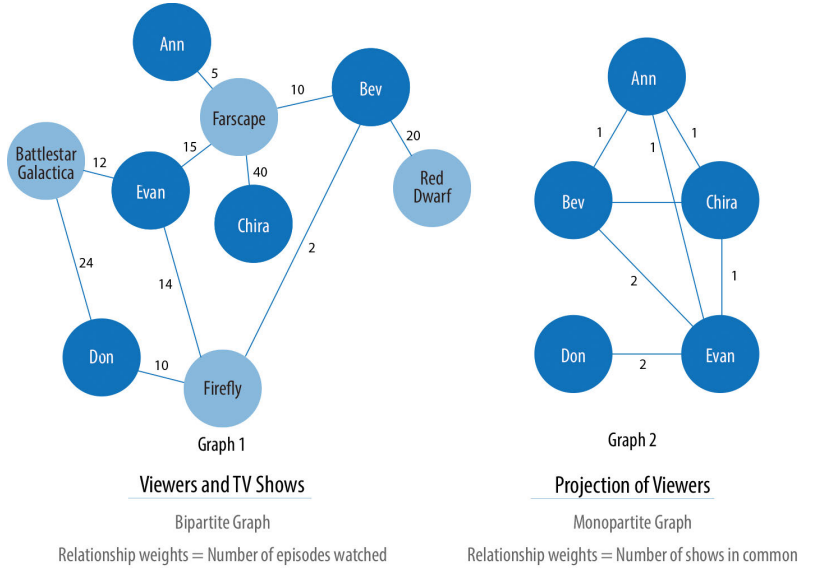

In [103]:
#Removendo os vertices que identicamos com o atributo COR, neste caso green para deixar os autores
to_remove = []
for node in G.nodes(data = True):
    if node[1]["COR"] == "green": ## check if the node is green
        to_remove.append(node[0])
        ## go over all neighbours of the node and add an edge between them
        neighbours =  list(G.neighbors(node[0]))
        for i in range(0, len(neighbours)-1):
            for j in range(i+1, len(neighbours)):
                G.add_edge(neighbours[i],neighbours[j])

## remove the green nodes
G.remove_nodes_from(to_remove)

Grafo é Monopartido.


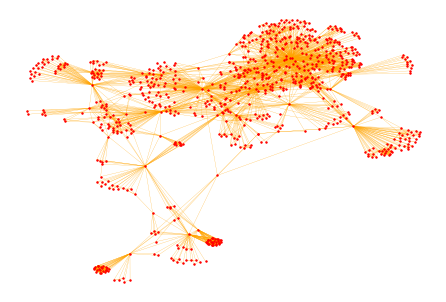

In [104]:
#Verifica se o grafo é bipartido
if nx.bipartite.is_bipartite(G):
    print('Grafo é Bipartido.')
    if nx.is_connected(G):
        print('Grafo está Conectado.')
        #Separar os dois conjuntos de vertices, verificação necessária porque se o Grafo não estiver conectado
        #Existirá mais de uma cor possível
        bottom_nodes, top_nodes = nx.bipartite.sets(G)
    else:
        top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
        bottom_nodes = set(G) - top_nodes
else:
    print('Grafo é Monopartido.')

    
#Plotando o novo Grafo
#Mostrar o Grafo sem os labels
nx.draw(G, pos=nx.spring_layout(G), with_labels=False, node_color='red', node_size=2, edge_color='orange', width=0.2)

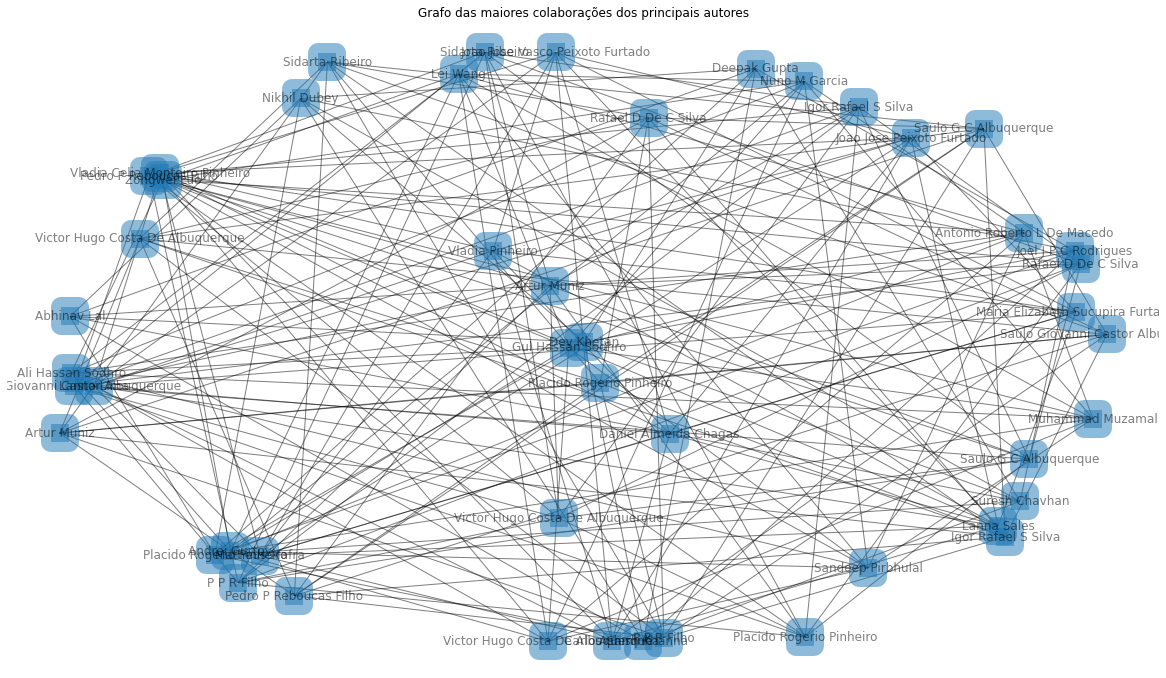

In [106]:
n = 5

top_collaboration = sorted(G.degree, key=lambda x: x[1], reverse=True)
top_collaboration[:n]

plt.figure(figsize=(16, 9))
for autor in top_collaboration[:n]:
    top_autores_cliques = []
    top_clique_autor = max(nx.cliques_containing_node(G, nodes=autor[0]), key=len)
    for a in top_clique_autor:
        top_autores_cliques.append(a)
        
    G1 = nx.subgraph(G, top_autores_cliques)
    nx.draw(G1, node_shape='s', with_labels=True, alpha=0.5, linewidths=20)

plt.title('Grafo das maiores colaborações dos principais autores')
plt.show()

In [114]:
#Os 10 Maiores Autores com artigos compartilhados
df_dados.AUTORES.value_counts().nlargest(10)

Victor Hug    175
Placido Ro    154
Joao Jose      53
Maria Eliz     52
Joel J P C     47
Adriano Be     42
Pedro P Re     40
Andre Luis     38
Maria Andr     38
J M R S Ta     30
Name: AUTORES, dtype: int64

<AxesSubplot:ylabel='AUTORES'>

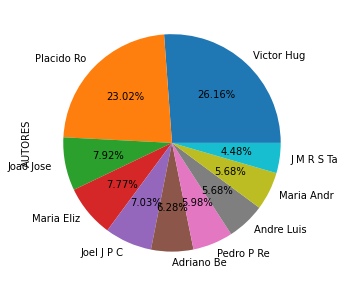

In [115]:
#Grafico dos 10 Maiores Autores com artigos compartilhados
df_dados.AUTORES.value_counts().nlargest(10).plot(kind='pie', autopct='%0.2f%%', figsize=(5,5))

In [116]:
#Os 10 Maiores Titulos com as maiores colaborações compartilhadas
df_dados.TITULO.value_counts().nlargest(10)

Automatic     56
Evaluation    48
Towards Th    39
The Crossc    33
A Novel Mo    27
Intelligen    26
Cloud Comp    23
An Approac    20
A Proposal    20
Efficient     17
Name: TITULO, dtype: int64

<AxesSubplot:ylabel='TITULO'>

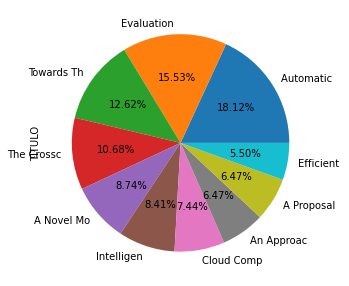

In [117]:
#Grafico dos 10 Maiores Titulos com as maiores colaborações compartilhadas
df_dados.TITULO.value_counts().nlargest(10).plot(kind='pie', autopct='%0.2f%%', figsize=(5,5))

In [118]:
#Os 10 Maiores Autores com Maior colaboração com outros autores
df_dados.groupby(['AUTORES']).TITULO.value_counts().nlargest(15)

AUTORES     TITULO    
Placido Ro  Towards Th    11
Victor Hug  Automatic      8
            Evaluation     8
J M R S Ta  Evaluation     5
Placido Ro  A Multi-Cr     5
Adriano Be  A Multi-Cr     4
Luis Henri  A Multi-Cr     4
Maria Eliz  An Approac     4
Mirian Cal  Towards Th     4
Pedro P Re  Automatic      4
Placido Ro  A Hybrid A     4
            A Hybrid M     4
            Applying A     4
            Applying V     4
Victor Hug  Intelligen     4
Name: TITULO, dtype: int64

<AxesSubplot:ylabel='TITULO'>

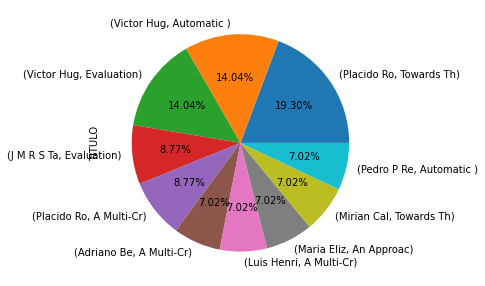

In [119]:
#Grafico dos 10 Maiores Autores com Maior colaboração com outros autores
df_dados.groupby(['AUTORES']).TITULO.value_counts().nlargest(10).plot(kind='pie', autopct='%0.2f%%', figsize=(5,5))

In [120]:
#Relacionamento de Autores x Titulos.
df_dados2 = pd.crosstab(df_dados.AUTORES, df_dados.TITULO)
idx = df_dados2.columns.union(df_dados2.index)
df_dados2 = df_dados2.reindex(index = idx, columns=idx, fill_value=0)
print (df_dados2)

             Escritori  'Processo   A #Hashtag  A Aguiar V  A Bicluste  \
 Escritori           0           0           0           0           0   
'Processo            0           0           0           0           0   
A #Hashtag           0           0           0           0           0   
A Aguiar V           0           0           0           0           0   
A Bicluste           0           0           0           0           0   
...                ...         ...         ...         ...         ...   
Zairan Li            0           0           0           0           0   
Zehong Cao           0           0           0           0           0   
Zhenzhong            0           0           0           0           0   
Zhifan Gao           0           0           0           0           0   
Zongwei Lu           0           0           0           0           0   

            A Bio-Insp  A Biomecha  A C Da S B  A C G Vare  A C Gastal  ...  \
 Escritori           0          

In [121]:
#Relacionamento de Autores x Autores.
df_dados2 = pd.crosstab(df_dados.AUTORES, df_dados.AUTORES)
idx = df_dados2.columns.union(df_dados2.index)
df_dados2 = df_dados2.reindex(index = idx, columns=idx, fill_value=0)
print (df_dados2)

AUTORES     A Aguiar V  A C Da S B  A C G Vare  A C Gastal  A C Pascal  \
AUTORES                                                                  
A Aguiar V           3           0           0           0           0   
A C Da S B           0           1           0           0           0   
A C G Vare           0           0           1           0           0   
A C Gastal           0           0           0           1           0   
A C Pascal           0           0           0           0           1   
...                ...         ...         ...         ...         ...   
Zairan Li            0           0           0           0           0   
Zehong Cao           0           0           0           0           0   
Zhenzhong            0           0           0           0           0   
Zhifan Gao           0           0           0           0           0   
Zongwei Lu           0           0           0           0           0   

AUTORES     A Galis  A Hohl  A M Bapt

In [122]:
#Relacionamento de Titulos x Titulos.
df_dados2 = pd.crosstab(df_dados.TITULO, df_dados.TITULO)
idx = df_dados2.columns.union(df_dados2.index)
df_dados2 = df_dados2.reindex(index = idx, columns=idx, fill_value=0)
print (df_dados2)

TITULO       Escritori  'Processo   A #Hashtag  A Bicluste  A Bio-Insp  \
TITULO                                                                   
 Escritori           2           0           0           0           0   
'Processo            0           3           0           0           0   
A #Hashtag           0           0           6           0           0   
A Bicluste           0           0           0           2           0   
A Bio-Insp           0           0           0           0          10   
...                ...         ...         ...         ...         ...   
Using Psyc           0           0           0           0           0   
Verbal Dec           0           0           0           0           0   
Visual Obj           0           0           0           0           0   
Web-Based            0           0           0           0           0   
Weighted L           0           0           0           0           0   

TITULO      A Biomecha  A Co-Evolu  A

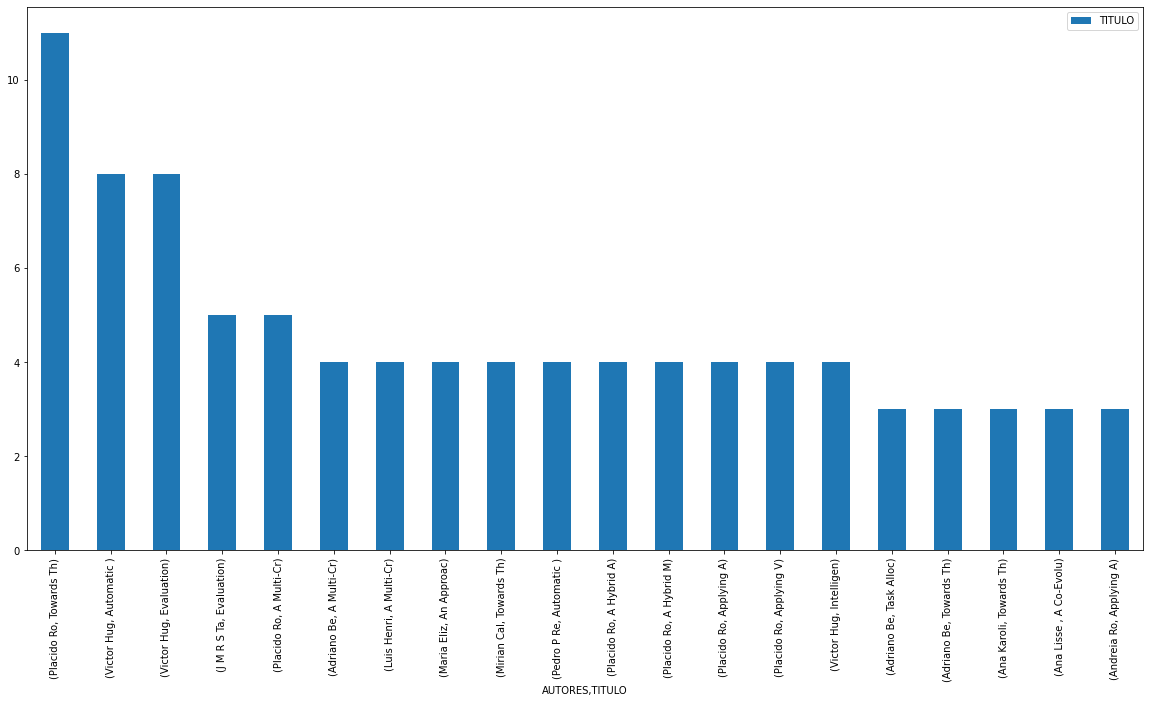

In [123]:
#Plotando um grafico de frequencia dos 10 maiores autores por titulos publicados
plt.figure(figsize=(20, 10))

df_dados.groupby(['AUTORES']).TITULO.value_counts().nlargest(20).plot.bar(legend=True)

plt.show()

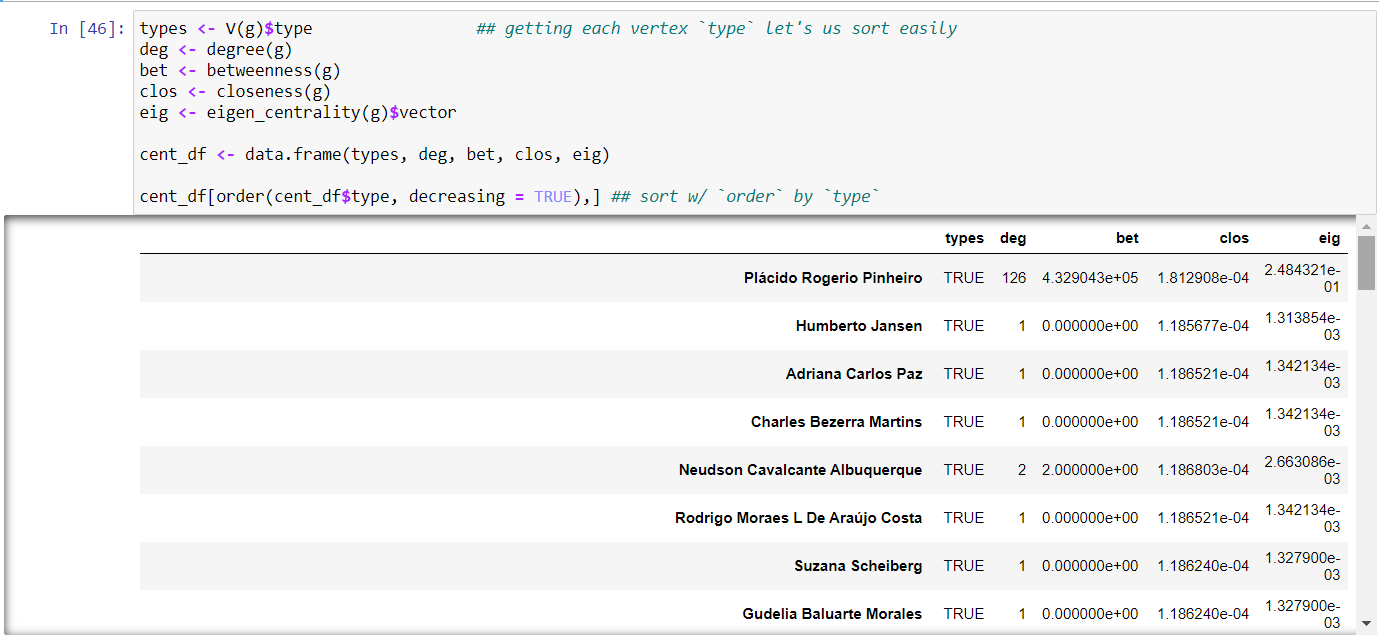

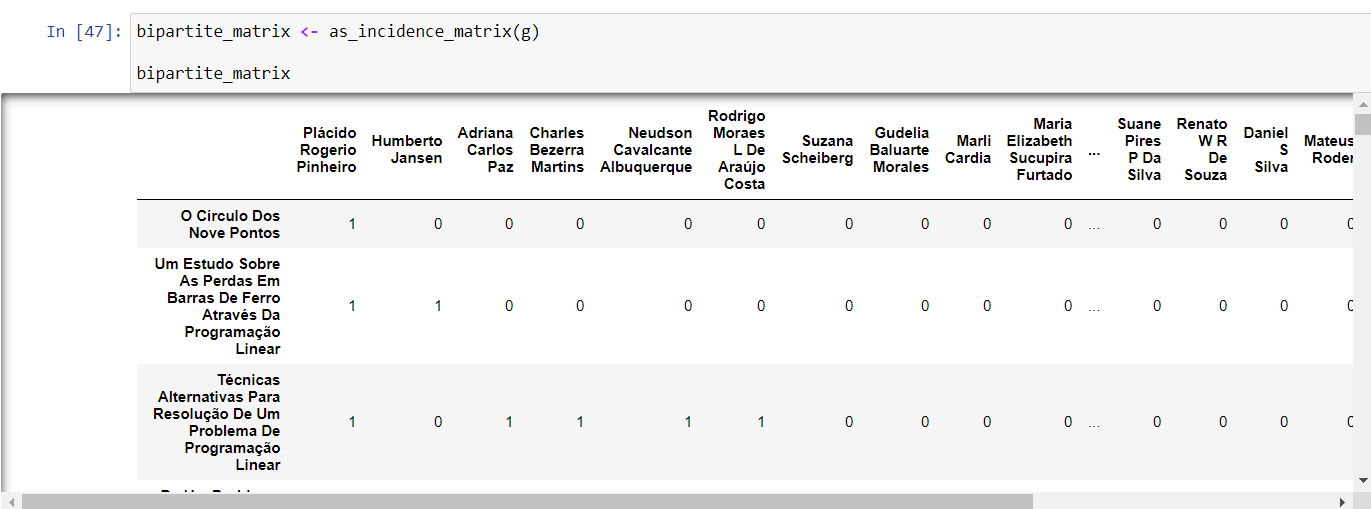

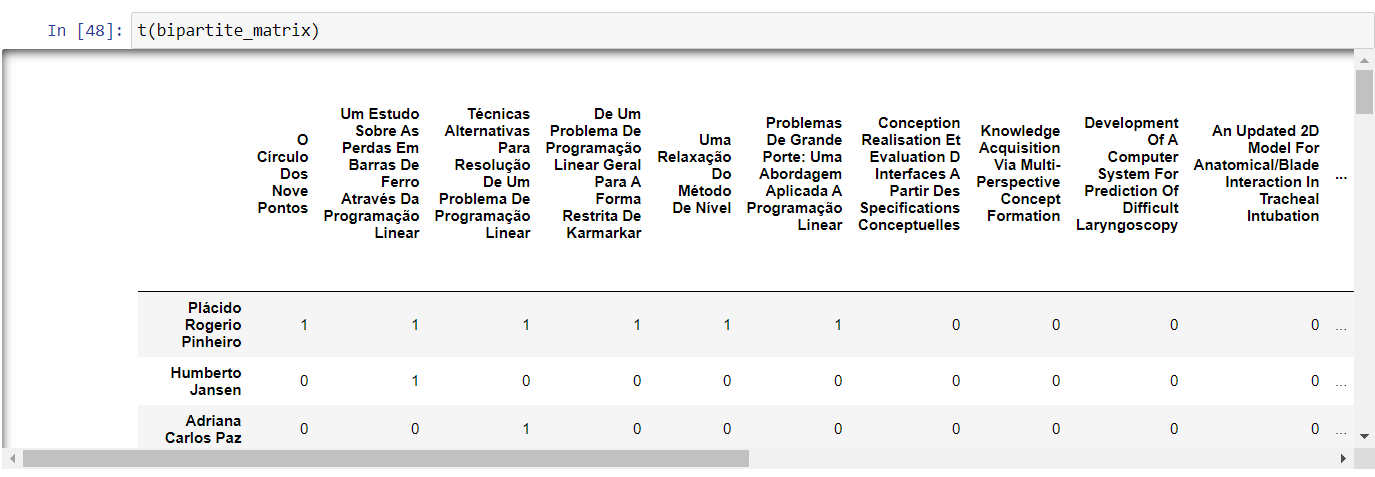

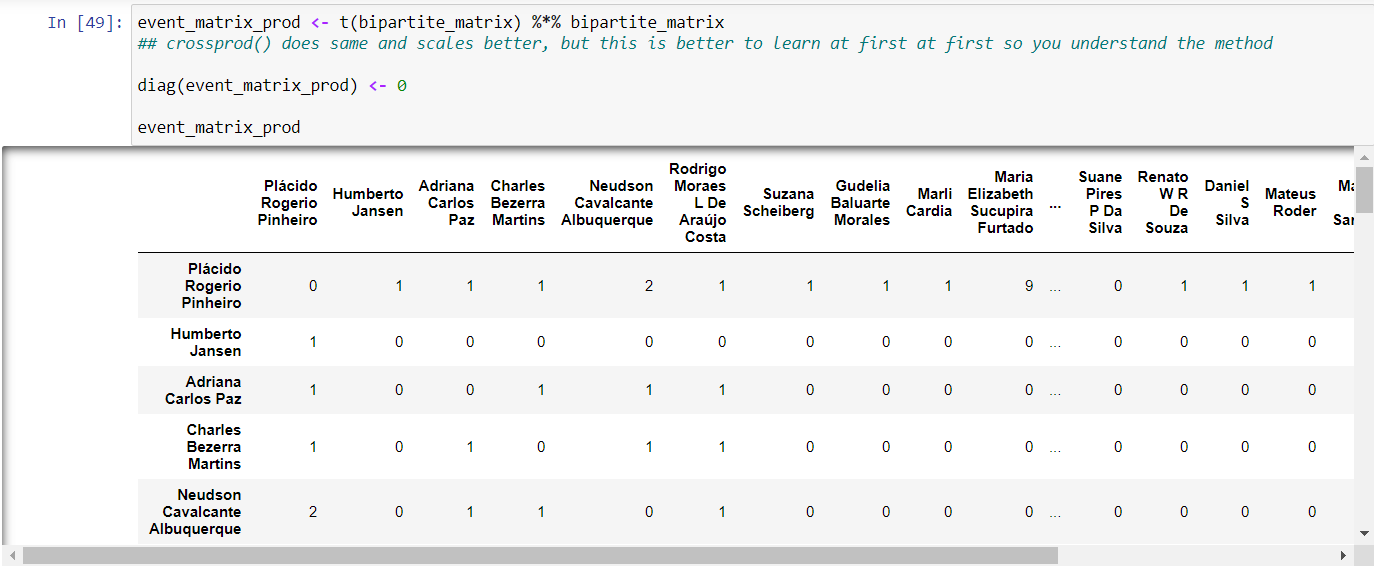

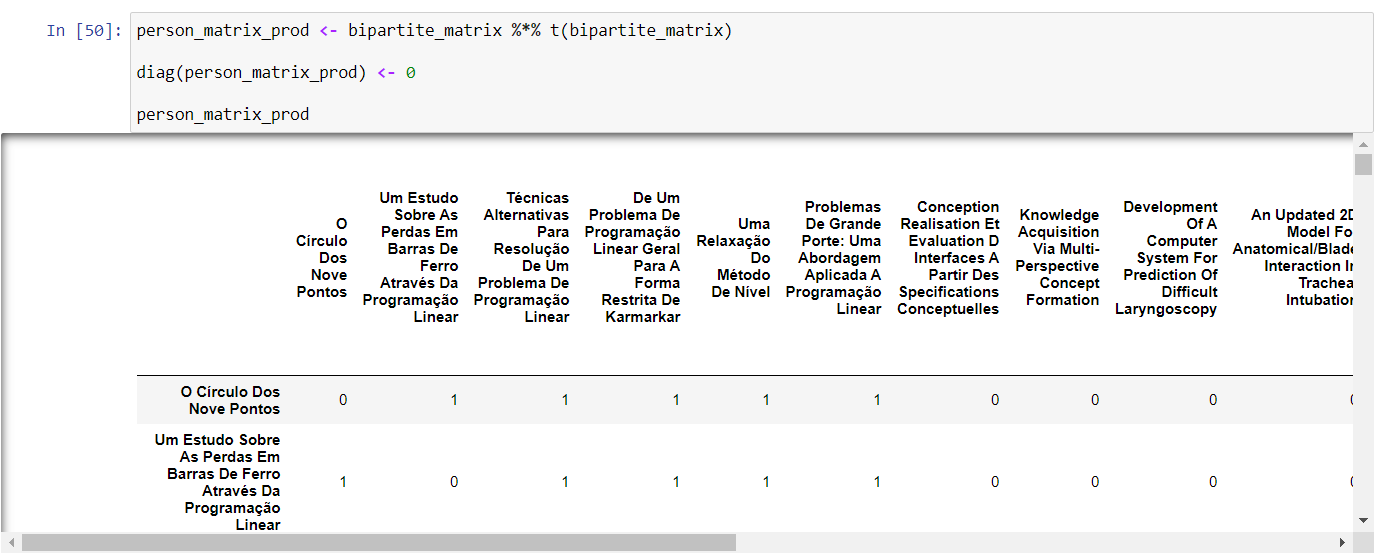

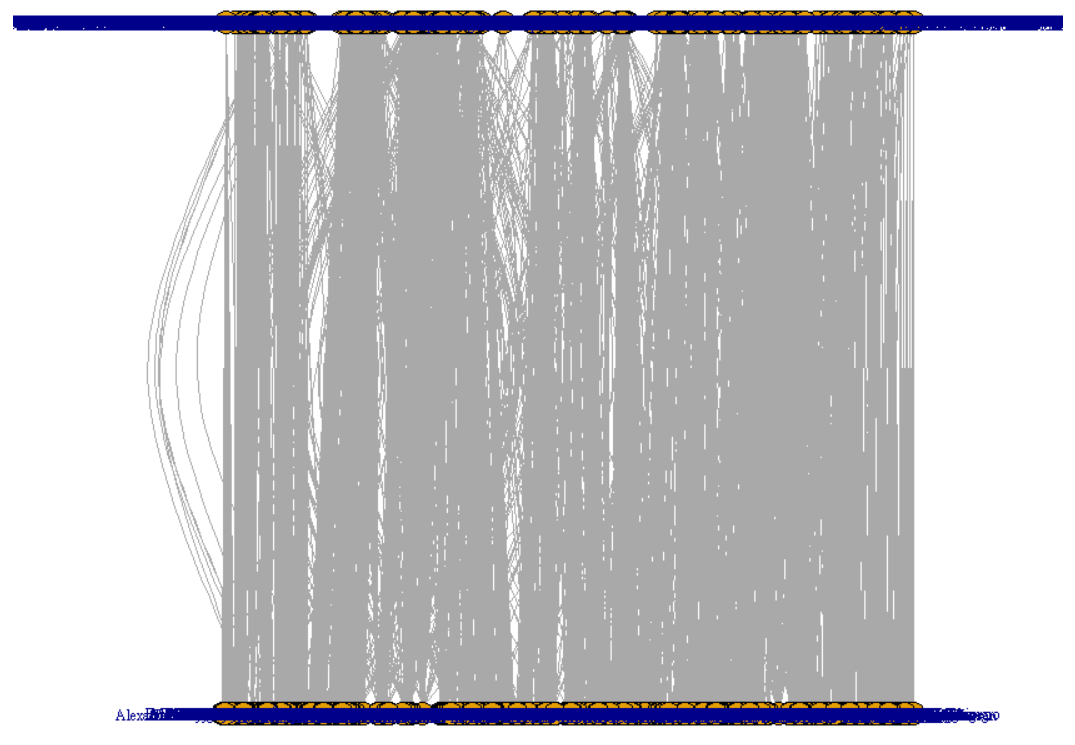

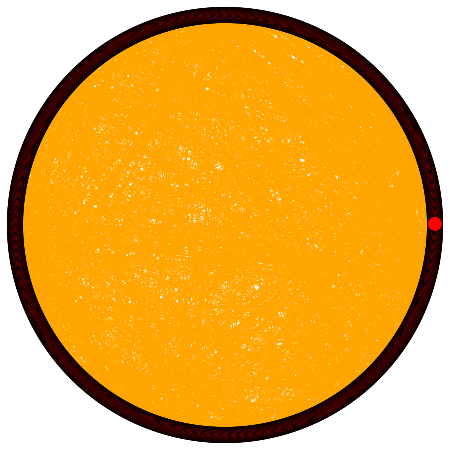

In [124]:
#Importando a biblioteca Ipgrah com Python
#Não encontrei na biblioteca Igraph uma forma de criar o grafo com layout bipartido por padrão, por isso migrei para o R
from igraph import *

##Criando o Grafo a partir do Dataframe
ig = Graph.DataFrame(df_dados, directed=False)

#Definindo o Layout do Gráfico
layout = ig.layout("circle")

##Criando o Estilo
visual_style = {}
##Layout
visual_style["layout"] = layout
visual_style["margin"] = 15
visual_style["vertex_size"] = 15
visual_style["vertex_shape"] = 'circle'
visual_style["bbox"] = (450, 450)
visual_style["edge_curved"] = 0
visual_style["edge_color"] = 'orange'

##Plotar o Grafo
plot(ig, **visual_style)